In [1]:
"""
@author Rahul Gupta
"""

import string
import re
import tweepy
import json
import twitterClient
from collections import Counter

import nltk
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import opinion_lexicon

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

from colorama import Fore, Style
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
plt.style.use('seaborn')
pd.set_option('display.max_columns', None)  
pd.options.display.max_colwidth = 200

In [2]:
class TwitterProcessing:
    def __init__(self, tokeniser, lStopwords):
        self.tokeniser = tokeniser
        self.lStopwords = lStopwords

    def process(self, text):
        text = text.lower()
        tokens = self.tokeniser.tokenize(text)
        tokensStripped = [tok.strip() for tok in tokens]
        regexDigit = re.compile("^\d+\s|\s\d+\s|\s\d+$")
        regexHttp = re.compile("^http")

        return [tok for tok in tokensStripped if tok not in self.lStopwords and
                regexDigit.match(tok) == None and regexHttp.match(tok) == None]

In [3]:
def computeSentiment(lTokens, setPosWords, setNegWords):
    posNum = len([tok for tok in lTokens if tok in setPosWords])
    negNum = len([tok for tok in lTokens if tok in setNegWords])
    return posNum - negNum

def countWordSentimentAnalysis(setPosWords, setNegWords, tweets, tweetProcessor):
    # Get tweet and remove duplicates
    tweet_text = list(set([tweet['text'] for tweet in tweets]))
    lSentiment = []
    for tweet in tweet_text:
        try:
            tokens = tweetProcessor.process(tweet)
            sentiment = computeSentiment(tokens, setPosWords, setNegWords)
            lSentiment.append([tweet, sentiment])
        except KeyError as e:
            pass
    return lSentiment

def vaderSentimentAnalysis(tweets, tweetProcessor):
    sentAnalyser = SentimentIntensityAnalyzer()
    lSentiment = []
    for tweet in tweets:
        try:
            tweetText = tweet['text']
            tweetDate = tweet['created_at']

            lTokens = tweetProcessor.process(tweetText)
            dSentimentScores = sentAnalyser.polarity_scores(' '.join(lTokens))
            lSentiment.append([pd.to_datetime(tweetDate), tweetText, dSentimentScores['compound']])

        except KeyError as e:
            pass
    return lSentiment

In [4]:
def save_tweets(query, max_tweets, output_file):
    api = twitterClient.twitter_client()
    tweets = []

    for tweet in tweepy.Cursor(api.search, q=query, lang="en").items(max_tweets):
        tweets.append(tweet._json)

    with open(output_file, 'w') as f:
        json.dump(tweets, f)

In [5]:
query = 'streaming service OR streaming movies OR streaming series'
max_tweets = 200
output_file = 'streaming_service.json'

# save_tweets(query, max_tweets, output_file)

Don't read the json file again and again

In [6]:
with open(output_file, 'r') as f:
    for line in f:
        tweets = json.loads(line)

In [7]:
tweetTokenizer = TweetTokenizer()
lPunct = list(string.punctuation)
lStopwords = stopwords.words('english') + lPunct + ['rt', 'via', '...', '…', '"', "'", '`','’', '‘']

tweetProcessor = TwitterProcessing(tweetTokenizer, lStopwords)

PosWords = opinion_lexicon.positive()
NegWords = opinion_lexicon.negative()

## Sentiment values

In [8]:
lSentiment = countWordSentimentAnalysis(PosWords, NegWords, tweets, tweetProcessor)

In [9]:
streaming_tweets = pd.DataFrame(lSentiment)
streaming_tweets.columns = ['text','Sentiment']

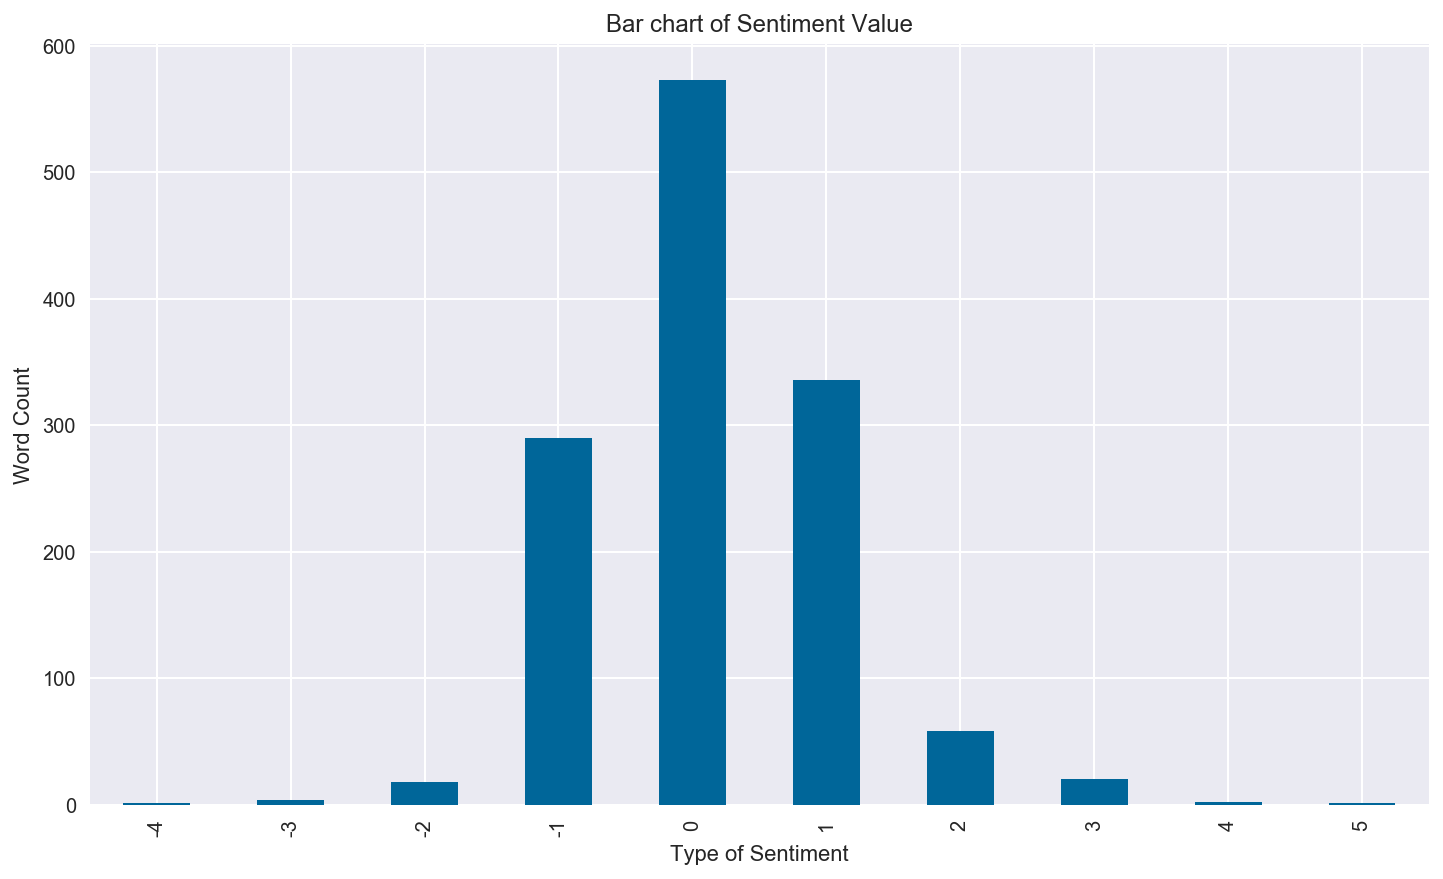

In [10]:
plt.rcParams["figure.figsize"] = (12,7)
pd.value_counts(streaming_tweets['Sentiment'].values, 
                sort=True, ascending=False).sort_index().plot(kind='bar', color='#006699')
plt.ylabel('Word Count')
plt.xlabel('Type of Sentiment')
plt.title('Bar chart of Sentiment Value')
plt.legend().set_visible(False)

* From the chart We can see most of the tweets for Media Streaming are Neutral

* Negative Tweets are Higher than the positive tweets

Next we can analyze some most positive and negative tweets

In [11]:
conditions = [
    (streaming_tweets['Sentiment'] > 0),
    (streaming_tweets['Sentiment'] < 0),
    (streaming_tweets['Sentiment'] == 0),]
choices = ['Positive', 'Negative', 'Neutral']
streaming_tweets['sentiment_type'] = np.select(conditions, choices)

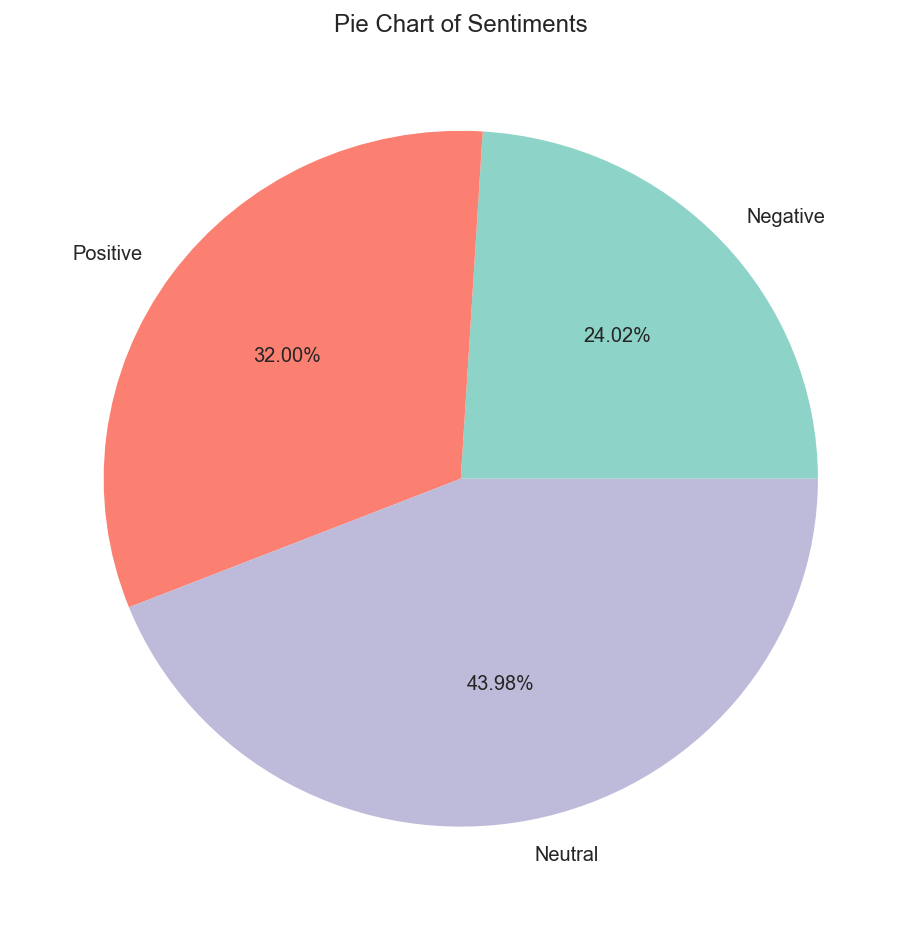

In [12]:
def make_pie_chart(data, column, title = 'Pie chart'):
    plt.rcParams["figure.figsize"] = (8,8)
    color_brewer_set2 = ["#8DD3C7","#FB8072","#BEBADA","#FFFFB3",
                         "#80B1D3","#FDB462","#B3DE69","#FCCDE5", ]

    pd.value_counts(data[column].values, sort=True, ascending=True). \
    plot(kind='pie',autopct='%1.2f%%', colors=color_brewer_set2)
    plt.title(f'Pie Chart of {title}')
    plt.xlabel('')
    plt.ylabel('')
make_pie_chart(streaming_tweets,'sentiment_type','Sentiments')

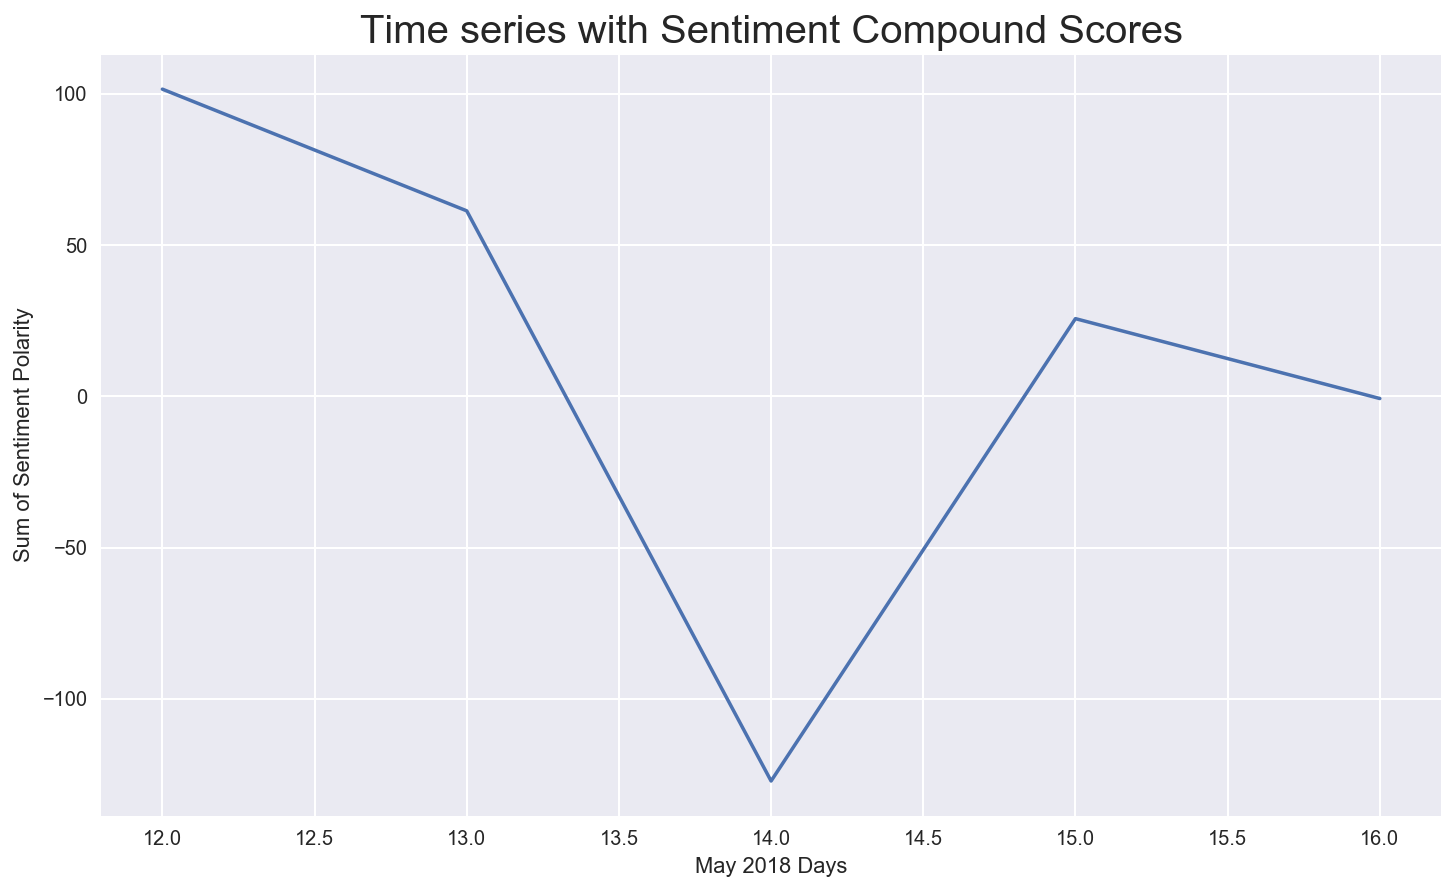

In [13]:
sentiment = vaderSentimentAnalysis(tweets, tweetProcessor)
streaming_compound = pd.DataFrame(sentiment)
streaming_compound.columns = ['Timestamp', 'text','compound']

times = pd.DatetimeIndex(streaming_compound['Timestamp'])
plt.rcParams["figure.figsize"] = (12,7)
streaming_compound.groupby(times.day).compound.sum().plot()
plt.title('Time series with Sentiment Compound Scores', fontsize=20)
plt.xlabel('May 2018 Days')
plt.ylabel('Sum of Sentiment Polarity')
plt.show()

We have many negative tweets on 14-May-2018. This need to be studied as it affected the whole data set polarity

## Key words analysis

**Most Used Keywords**

In [14]:

def get_frequent_keywords(tweets, tweetProcessor, limit=15):
    tweet_text = set([tweet['text'] for tweet in tweets])
    freq_counter = Counter()
    for tweet in tweet_text:
        tokens = tweetProcessor.process(tweet)
        freq_counter.update(tokens)
    return freq_counter.most_common(limit)

In [15]:
freq = get_frequent_keywords(tweets, tweetProcessor)
freq_df = pd.DataFrame(freq, columns=['word','count'])
freq_df.sort_values('count', ascending=False, inplace=True)

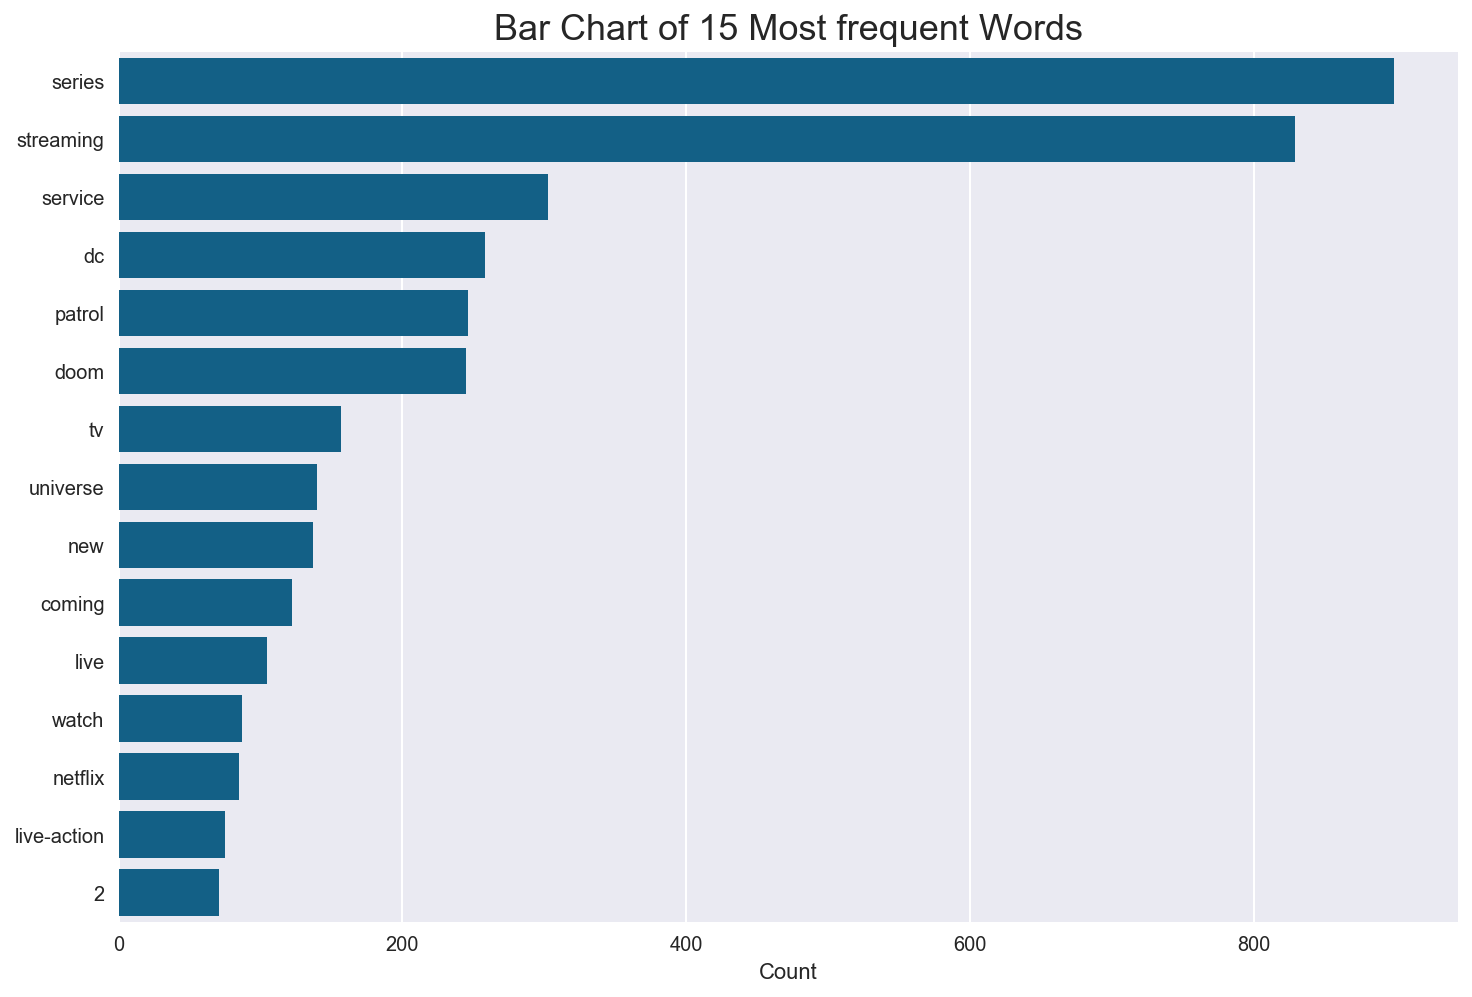

In [16]:
import seaborn as sns
plt.rcParams['figure.figsize'] = (12, 8)
sns.barplot(x='count', y='word', data=freq_df, color='#006699')
plt.title('Bar Chart of 15 Most frequent Words', fontsize=18)
plt.ylabel('')
plt.xlabel('Count')
plt.show()

## Hashtag frequency

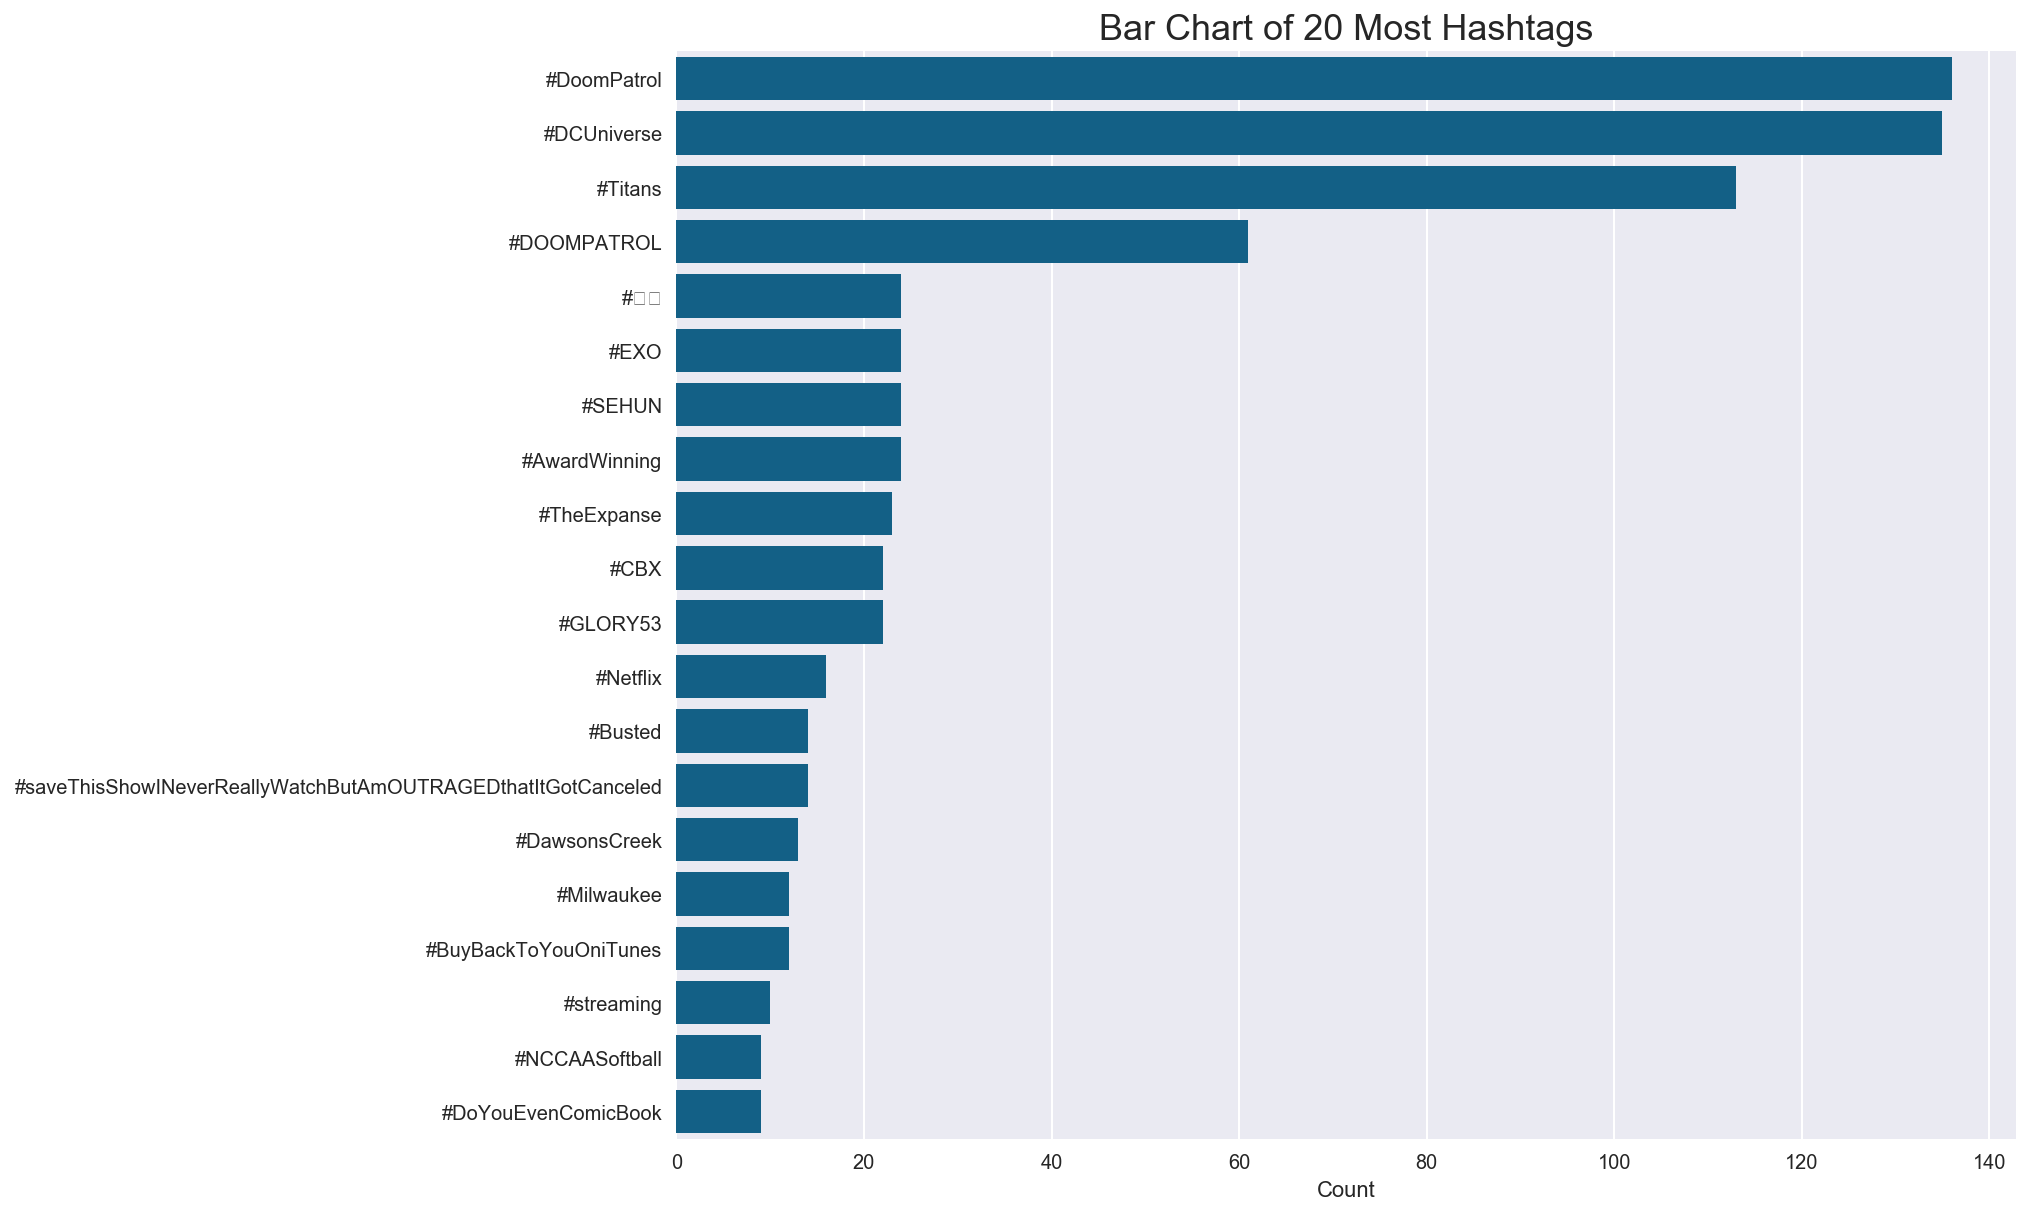

In [17]:
hashtag = []
for tweet in tweets:
    if tweet['entities']['hashtags'] != []:
        for i in tweet['entities']['hashtags']:
            hashtag.append('#' + i['text'])

freq_counter = Counter()
freq_counter.update(hashtag)
freq_df = pd.DataFrame(freq_counter.most_common(20), columns=['word','count'])
freq_df

plt.rcParams['figure.figsize'] = (12, 10)
sns.barplot(x='count', y='word', data=freq_df, color='#006699')
plt.title('Bar Chart of 20 Most Hashtags', fontsize=18)
plt.ylabel('')
plt.xlabel('Count')
plt.show()

### Top Negative Tweets

In [18]:
streaming_tweets.sort_values('Sentiment', inplace=True)
top_negative = list(streaming_tweets.iloc[0:5]['text'])
for text in top_negative:
    print(text)

Any series: you want garbage? You want fucking garbage? You want this bastard we literally pulled out of our garbag… https://t.co/pl0rsz6pFZ
Fear the Walking Dead is a good show, but they (the characters) made idiot mistakes all the time. I guess it make t… https://t.co/iz6PnzvBcH
Current planned games for streaming:
Far Cry 4 / Far Cry 5
Current planned games for Youtube:
Dark Souls series
Und… https://t.co/PjFjuPcmaY
Netflix’s Dark is hard to watch, and impossible to stop watching https://t.co/1bzvUDKZPF via @Verge
It's funny that complex media (streaming TV series, video games) know exactly which parts killed user interest, but… https://t.co/aod6nvBKlp


### Top Positive Tweets

In [19]:
top_positive = list(streaming_tweets['text'].tail())
for text in top_positive:
    print(text)

Just finished watching all 8 episodes of #Safe in one sitting!  What a great mini series worthy of an award for bes… https://t.co/DkVXi8DX9I
@billboard hi, Euphoria will be released in the ep love yourself: wonder or in the repackage of the series, so the… https://t.co/MYqaJGSb1K
Huge congratulations to @VanessaKirby on her Best Supporting Actress win at #BAFTAs2018 for @TheCrownNetflix 🏆🍾 Ver… https://t.co/eUNS0NJvay
RT @ManaByte: Disney is going to want a Marvel series on the streaming service that will make Marvel fans want to pay for the service, like…
How are you a work in progress?

'Work In Progress,' our new original comedy series, now streaming for FREE only on… https://t.co/qx827dt0JE


## Famous Tweets by Retweet Count

For this we need to analysis top retweeted and liked posts

In [20]:
top_retweets = pd.DataFrame([[i['text'], i['retweet_count']] for i in tweets])
top_retweets.columns = ['text', 'retweet_count']
top_retweets.sort_values('retweet_count', ascending=False, inplace=True)
top_retweets.drop_duplicates('text', inplace=True)
top_retweets.iloc[:10]

,text,retweet_count
166,RT @netflix: .@Logic301\n@Rapsody\n@2chainz\n@tip\n@artisthbtl\n@daveeast\n@justblaze\n@G_Eazy\n@nas\nand\n@Netflix\n\nTheir Words. Their Way. \nRapture…,14155
2189,"RT @cwtvd: See Elena’s return on the series finale of #TVD, streaming now on The CW App: https://t.co/hXUCSvJKWV https://t.co/6fs1SGxYKS",3499
2188,"RT @cwtvd: See one last battle with #TVD’s greatest villain on the series finale, now streaming on The CW App: https://t.co/hXUCSvJKWV http…",2700
1969,RT @exo_schedules: DAILY SCHEDULE 🗓 180510 | 10th May | #엑소 #EXO #CBX Schedule\n\n💻 Netflix series [#SEHUN]\n🎤 Concert + Meet &amp; Greet [#CBX_Ma…,1701
2302,"RT @netflix: .@Logic301 @Rapsody @2chainz @tip @artisthbtl @daveeast @justblaze @G_Eazy &amp; @nas\n\nTheir Words. Their Way. @RaptureNetflix, an…",1611
2068,RT @exo_schedules: DAILY SCHEDULE 🗓 180504 | 4th May | #엑소 #EXO Schedule\n\n🎉 Youth Day festival [#LAY]\n💻 Netflix series [#SEHUN]\n📺 TV Appear…,1290
1881,"RT @stevenfurtick: ""Do you have the stones?"" - The final installment in our #WAYMAKER series is now streaming - link in profile. https://t.…",363
1692,RT @infamousmargot: ❗️DC have released the official logo for the upcoming R-Rated Harley Quinn animated TV series that will air on a new DC…,305
1891,RT @brickblock_io: The 10th edition of the 'Blockchain for Real Estate' series in Berlin will start in 30 minutes (7 pm CET).\n\nTune in to t…,248
2371,RT @SeIGomezUK: We’ve added #BackToYou 100 times to our streaming playlist! \n\nPlay it with headphones in to help the song’s streams! \n\nPlay…,203


## Famous Tweets by Likes

The data is not matching with online likes 

In [21]:
top_favorites = pd.DataFrame([[i['text'], i['favorite_count']] for i in tweets])
top_favorites.columns = ['text', 'favorite_count']
top_favorites.sort_values('favorite_count', ascending=False, inplace=True)
top_favorites.drop_duplicates('text', inplace=True)
top_favorites.iloc[0:10]

,text,favorite_count
1306,They're doing it! Doom Patrol is getting a show!\nhttps://t.co/YHDBPUN1G6,659
1092,A Doom Patrol series is coming to the DC Streaming Service in 2019!\n\nhttps://t.co/fI6V1kzYKc https://t.co/QNO4A0IhwP,368
1483,Doom Patrol live-action TV series announced for DC's streaming service https://t.co/ED5NgJ9QM4,245
591,Disney is going to want a Marvel series on the streaming service that will make Marvel fans want to pay for the ser… https://t.co/DLmOpYsLp7,136
1705,"DSTV: Hasn't changed their business model in 10 years, keeps showing the same stuff over and over, charges outrageo… https://t.co/YEkLSrhpxW",122
2462,"@JamesSACorey If any series deserves a pick-up by another net or streaming service, it is one of the best sci-fi series ever, #TheExpanse",118
1594,Back To You is on track to debut at #37 in the UK. Keep buying and streaming UK Selenators to get Selena her 13th t… https://t.co/cPovnywsEw,89
1515,DOOM PATROL SERIES COMING FROM DC UNIVERSE! https://t.co/NgHnaTozzX https://t.co/8bUy5K9vbf,85
1399,DOOM PATROL Series Coming to DC UNIVERSE Streaming Service https://t.co/xhv4BsnH9D via @Newsarama,84
1516,#Titans Offshoot #DoomPatrol Ordered at #DCUniverse Streaming Service https://t.co/3tBDbP4RCn via @AndySwift,76


## Relationship between Retweet count and followers

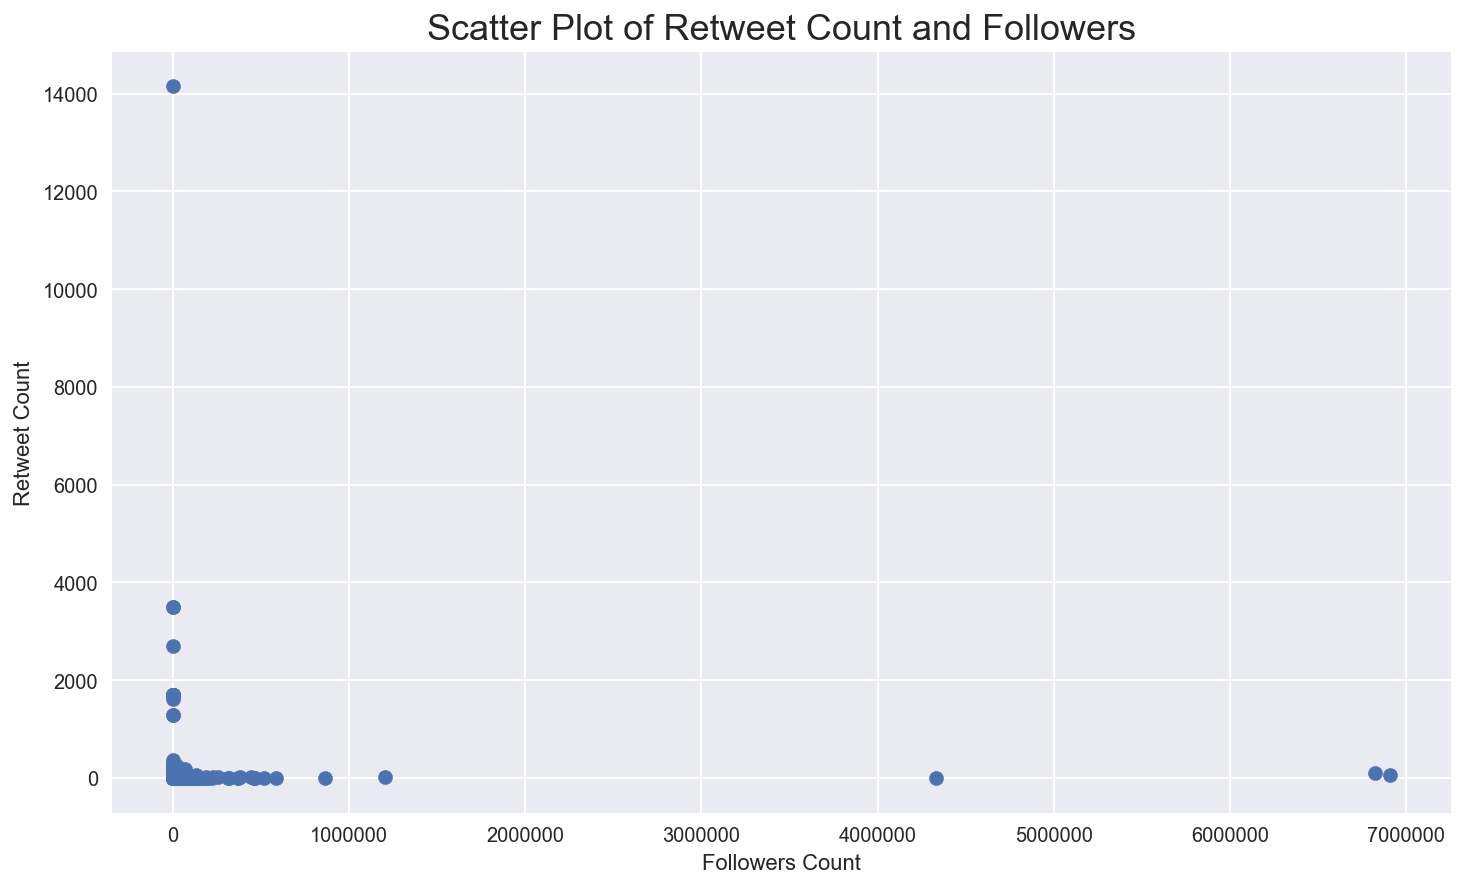

In [22]:
top_users = pd.DataFrame([[i['text'], i['retweet_count'], i['favorite_count'],
                           i['user']['followers_count'], i['user']['screen_name']] for i in tweets])
top_users.columns = ['text', 'retweet_count', 'favorite_count', 'followers_count', 'screen_name']

plt.rcParams['figure.figsize'] = (12, 7)
plt.scatter(top_users['followers_count'], top_users['retweet_count'])
plt.title('Scatter Plot of Retweet Count and Followers', fontsize=18)
plt.ylabel('Retweet Count')
plt.xlabel('Followers Count')
plt.show()
plt.show()

There is no correlation between followers and retweet count

In [23]:
from scipy.stats.stats import pearsonr
pearsonr(top_users['followers_count'], top_users['retweet_count'])

(-0.0033617558560311723, 0.8665799715766822)

## Topic Modelling

In [24]:
tweet_text = top_retweets['text'][top_retweets['retweet_count'] > 0].tolist()
topic_tokens = []
for tweet in tweet_text:
    tokens = tweetProcessor.process(tweet)
    topic_tokens.append(' '.join(tokens))

no_features = 1500

tfVectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=no_features, stop_words='english')
tf = tfVectorizer.fit_transform(topic_tokens)
tfFeatureNames = tfVectorizer.get_feature_names()
ldaModel = LatentDirichletAllocation(n_components=10, max_iter=10, learning_method='online').fit(tf)

for topicId, lTopicDist in enumerate(ldaModel.components_):
    print("Topic %d:" % (topicId))
    print(" ".join([tfFeatureNames[i] for i in lTopicDist.argsort()[:-10 - 1:-1]]))

Topic 0:
watch streaming great redsleep_series series starring sports nbc live winning
Topic 1:
series streaming gay paper boys binge husbands netflix event super
Topic 2:
streaming series service dc doom patrol live coming action doompatrol
Topic 3:
streaming series set jon star force return wars favreau awakens
Topic 4:
series tv streaming like finale lucifer syfy live vs know
Topic 5:
series streaming new season episode hulu tonight today live batman
Topic 6:
streaming okay uk rocky unlimited imagine opt usage primevideoca 90
Topic 7:
series produce team tv god come start join stars continue
Topic 8:
stream maybe gt3 free velocityemag fixed mixed aussie iracing velocitysimracing
Topic 9:
series race solid 30 grand watching drivers prix indycar entertainment
